In [1]:
import os
import snscrape.modules.twitter as sntwitter
import pandas as pd
import nltk #Need to download prior
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import datetime

In [2]:
#Returning dataframe with tweets, filtering replies and links from 2016 forward
def get_tweets(username,n=1000):
    output = []
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+username+' -filter:replies -filter:links since:2016-01-01').get_items()):
        if i == n:
            break
        output.append([tweet.date, tweet.content, tweet.user.username])
    return pd.DataFrame(output, columns=['Datetime', 'Text', 'Username'])

In [78]:
#Importing spreadsheet of twitter handles to loop through
players = pd.read_csv (r'C:\Users\Raymond Luu\Desktop\Liang\Melee-Twitter-Sentiment-Analysis\Melee Twitters.csv')

#Filtering out those without Twitters
players = players[~pd.isnull(players.Twitter)]

#Lowercase
players['Twitter'] = players['Twitter'].str.lower()

In [4]:
get_tweets('ssbmhax',n=1000)

,Datetime,Text,Username
0,2021-02-01 20:46:54+00:00,looks like i'm single this valentine's day.......,ssbmhax
1,2021-01-31 22:41:49+00:00,you know they're a homie when they homie stock...,ssbmhax
2,2021-01-27 21:51:45+00:00,daaaaaaaaaaaamn just went to gamestop and they...,ssbmhax
3,2021-01-26 20:49:07+00:00,genesis 7 was a year ago... what the fuck,ssbmhax
4,2021-01-16 23:55:13+00:00,2021 melee power rankings\n\n3. mango\n2. zain...,ssbmhax
...,...,...,...
178,2016-03-27 04:08:57+00:00,if you ever see me play like complete shit it'...,ssbmhax
179,2016-03-18 23:56:22+00:00,sad to watch PP play like this... my insomnia ...,ssbmhax
180,2016-02-29 19:10:08+00:00,18-3 vs lambchops in fox vs falco yesterday\n\...,ssbmhax
181,2016-02-21 21:13:37+00:00,8=============================================...,ssbmhax


In [5]:
tweets = []
for user in players.Twitter:
    tweet_history = get_tweets(user,n=1000)
    tweets.append(tweet_history)
    
all_tweets = pd.concat(tweets)

all_tweets['Username'] = all_tweets['Username'].str.lower()

all_tweets

,Datetime,Text,Username
0,2021-02-18 22:36:03+00:00,"Hi all,\n\nEarlier today I uploaded a video of...",LiquidHbox
1,2021-02-12 19:18:39+00:00,anything is clutchable if you believe in yourself,LiquidHbox
2,2021-02-08 03:14:39+00:00,tom brady is decent at football,LiquidHbox
3,2021-02-07 04:01:05+00:00,what is a stalemate,LiquidHbox
4,2021-01-08 06:29:21+00:00,my full time job is entering online smash tour...,LiquidHbox
...,...,...,...
166,2017-07-09 10:46:13+00:00,I think @HS_Orange and @Powder_HS combined cr...,SnowyHSS
167,2017-04-29 23:07:01+00:00,"Played beyond awful in melee, idk how i can 3-...",SnowyHSS
168,2017-04-29 22:12:57+00:00,I hugged @C9Mang0 after our set PogChamp,SnowyHSS
169,2017-04-29 17:44:45+00:00,Im 5-2 in Hearthstone Grand with a lead over H...,SnowyHSS


In [6]:
#Creating functions to attach VADER's polarity scores to a player's tweet history
sid = SIA()

#use 'pos', 'neu', 'neg', 'compound' for value
def get_polarity_val(df,value):
    return sid.polarity_scores(df.Text)[value]

#Using thresholds as recommended by VADER's documentation
def classify(df):
    if df.compound > 0.05:
        return 'positive'
    elif df.compound < -0.05:
        return 'negative'
    else:
        return 'neutral'

#Adding all new values to df
def add_polarity(df):
    df['pos'] = df.apply(lambda i: get_polarity_val(i,'pos'), axis=1)
    df['neu'] = df.apply(lambda i: get_polarity_val(i,'neu'), axis=1)
    df['neg'] = df.apply(lambda i: get_polarity_val(i,'neg'), axis=1)
    df['compound'] = df.apply(lambda i: get_polarity_val(i,'compound'), axis=1)
    df['class'] = df.apply(lambda i: classify(i), axis=1)

In [7]:
#Adding polarity values
add_polarity(all_tweets)

all_tweets

,Datetime,Text,Username,pos,neu,neg,compound,class
0,2021-02-18 22:36:03+00:00,"Hi all,\n\nEarlier today I uploaded a video of...",LiquidHbox,0.099,0.901,0.000,0.5423,positive
1,2021-02-12 19:18:39+00:00,anything is clutchable if you believe in yourself,LiquidHbox,0.000,1.000,0.000,0.0000,neutral
2,2021-02-08 03:14:39+00:00,tom brady is decent at football,LiquidHbox,0.000,1.000,0.000,0.0000,neutral
3,2021-02-07 04:01:05+00:00,what is a stalemate,LiquidHbox,0.000,1.000,0.000,0.0000,neutral
4,2021-01-08 06:29:21+00:00,my full time job is entering online smash tour...,LiquidHbox,0.042,0.682,0.276,-0.8027,negative
...,...,...,...,...,...,...,...,...
166,2017-07-09 10:46:13+00:00,I think @HS_Orange and @Powder_HS combined cr...,SnowyHSS,0.412,0.588,0.000,0.7430,positive
167,2017-04-29 23:07:01+00:00,"Played beyond awful in melee, idk how i can 3-...",SnowyHSS,0.133,0.590,0.277,-0.5994,negative
168,2017-04-29 22:12:57+00:00,I hugged @C9Mang0 after our set PogChamp,SnowyHSS,0.351,0.649,0.000,0.4019,positive
169,2017-04-29 17:44:45+00:00,Im 5-2 in Hearthstone Grand with a lead over H...,SnowyHSS,0.405,0.595,0.000,0.9231,positive


In [27]:
#Adding additional date columns for easier visualizations
all_tweets['year_month'] = all_tweets.Datetime.dt.strftime("%Y/%m")
all_tweets['date'] = all_tweets.Datetime.dt.date

In [28]:
#Creating object for plotting by month
positive_by_month = all_tweets.groupby('year_month')['class'].value_counts(normalize=True).rename('count').reset_index()
pos_month = positive_by_month[positive_by_month['class'] == 'positive']
pos_month

,year_month,class,count
0,2016/01,positive,0.475638
3,2016/02,positive,0.539267
6,2016/03,positive,0.483516
9,2016/04,positive,0.533007
12,2016/05,positive,0.518325
...,...,...,...
171,2020/10,positive,0.459627
174,2020/11,positive,0.506108
177,2020/12,positive,0.475000
180,2021/01,positive,0.471429


<ipython-input-41-91399db1be10>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


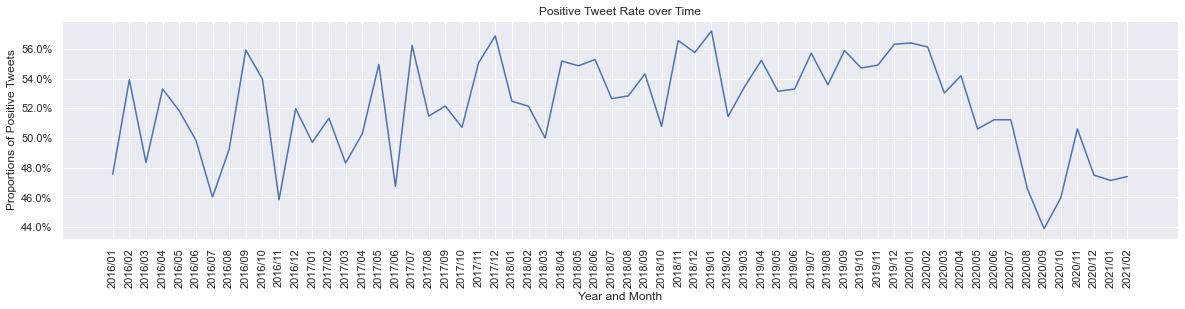

In [41]:
#Line plot of Compound over months and years
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

sns.lineplot(x="year_month", y="count", estimator="mean", data=pos_month, ax=ax)
plt.xticks(rotation=90)
ax.set_ylabel('Proportions of Positive Tweets')
ax.set_xlabel('Year and Month')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

plt.title('Positive Tweet Rate over Time')
plt.show()

In [88]:
all_tweets_with_char = pd.merge(all_tweets, players, left_on=  ['Username'],
                   right_on= ['Twitter'], 
                   how = 'left')
all_tweets_with_char

In [97]:
all_tweets_with_char_pos = all_tweets_with_char.groupby('Username')['class'].value_counts(normalize=True).rename('count').reset_index()
pos_user = all_tweets_with_char_pos[all_tweets_with_char_pos['class'] == 'positive']
pos_user.sort_values(by='count')

,Username,class,count
7,amsaredyoshi,positive,0.116000
103,lfgbimbo,positive,0.166667
123,michaels_nut,positive,0.355140
115,ma_therealthing,positive,0.382353
57,htwa_,positive,0.387000
...,...,...,...
150,professorprouk,positive,0.688073
104,liquidchu,positive,0.689655
39,drephen,positive,0.704225
183,snowyhss,positive,0.742690


In [106]:
main_pos = all_tweets_with_char.groupby('Main')['class'].value_counts(normalize=True).rename('count').reset_index()
main_pos_final = main_pos[main_pos['class'] == 'positive']

main_pos_final1 = main_pos_final.sort_values(by='count', ascending = False)
main_pos_final1

,Main,class,count
30,Pikachu,positive,0.680000
15,Ice Climbers,positive,0.605315
33,Samus,positive,0.582000
12,Ganon,positive,0.569000
27,Peach,positive,0.554885
6,Falco,positive,0.547595
24,Marth,positive,0.540195
9,Fox,positive,0.529708
0,Captain Falcon,positive,0.515450
18,Jigglypuff,positive,0.510784


In [107]:
unique_mains = all_tweets_with_char.groupby('Main')['Username'].agg(['nunique'])

In [115]:
main_pos_final2 = pd.merge(main_pos_final1, unique_mains, on=  ['Main'], 
                   how = 'left')
main_pos_final2.rename(columns = {'nunique':'Players', 'count':'Positive Rate'}, inplace = True) 

main_pos_final2.drop('class', axis=1)

,Main,Positive Rate,Players
0,Pikachu,0.680000,1
1,Ice Climbers,0.605315,5
2,Samus,0.582000,2
3,Ganon,0.569000,1
4,Peach,0.554885,8
5,Falco,0.547595,11
6,Marth,0.540195,13
7,Fox,0.529708,21
8,Captain Falcon,0.515450,8
9,Jigglypuff,0.510784,4
